<a href="https://colab.research.google.com/github/hank199599/data_science_from_scratch_reading_log/blob/main/Chapter21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 自然語言處理(NLP,Nature Language Process)
指的是一些與自然語言相關的計算技術

# 單詞雲 (word clouds)
根據單詞出現的次數，來決定字體的大小。

In [4]:
data = [("big data",100,15),("Hadoop",95,25),("Python",75,50),("R",50,40),("machine learning",80,20),("statistics",20,60),("data science",60,70),("analytics",90,3),("team player",85,85),("dynamic",2,90),("synergies",70,0),("actionable insights",40,30),("think out of box",45,10),("self-starter",30,50),("customer focus",65,15),("thought leadership",35,35)]

### 圖 21-1 一個由流行語所組成的單詞雲

In [5]:
!pip3 install wordcloud

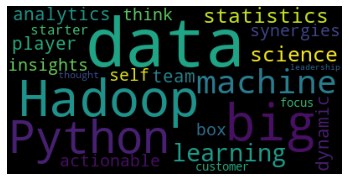

In [6]:
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text=""

for word in data:
  text=text+" "+word[0]

#for word in array:
cloud = WordCloud().generate(text)
plt.imshow(cloud)
plt.axis("off")
plt.show()

### 圖 21-2 一個較有意義的單詞雲

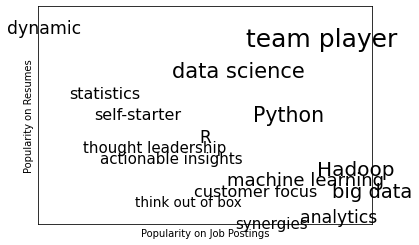

In [7]:
from matplotlib import pyplot as plt

def text_size(total:int) ->float:
  """如果total是0就送出8，如果total是200就送出28"""
  return 8+total/200*20

for word,job_popularity,resume_popularity in data:
  plt.text(job_popularity,resume_popularity,word,ha="center",va="center",size=text_size(job_popularity+resume_popularity))

plt.xlabel("Popularity on Job Postings")
plt.ylabel("Popularity on Resumes")
plt.axis([0,100,0,100])
plt.xticks([])
plt.yticks([])
plt.show()

# N-gram 語言模型
找出一堆文件語料庫，然後學習語言的統計模型

## 2-gram (bigram)
1. 針對某個起始單詞，查出原始文件中皆在這個單詞後面的所有單詞
2. 自其中隨機選擇一個做為下一個單詞
3. 重複這個動作(1. 2.)直到選中代表句子結束的句號。

In [8]:
def fix_unicode(text:str) ->str:
  return text.replace(u"\u2019","'")

In [9]:
import re
from bs4 import BeautifulSoup
import requests

url = "https://www.oreilly.com/ideas/what-is-data-science"
html = requests.get(url).text
soup = BeautifulSoup(html,'html5lib')

content = soup.find("div","main-post-radar-content")
regex = r"[\w']+|[\.]"

document = []

for paragraph in content("p"):
  words = re.findall(regex,fix_unicode(paragraph.text))
  document.extend(words)

只要其中一個輸入項無資料則結束壓縮，  
運用zip(document,doucment[1:])即可精確取得整個文件的連續單詞對

In [10]:
from collections import defaultdict

transitions = defaultdict(list)
for prev,current in zip(document,document[1:]):
  transitions[prev].append(current)

製作出一些句子

In [11]:
import random

def generate_using_bigrams() ->str:
  current = "." #表示下一個單詞將會是某個句子的起始單詞
  result = []
  while True:
    next_word_candidates = transitions[current]  # bigrams (current,_)
    current = random.choice(next_word_candidates) # 隨機挑選其中一個
    result.append(current)              # 添加至結果後面
    if current == ".":return " ".join(result) # 若遇到「.」就完成了


In [12]:
generate_using_bigrams()

'It would be dealing with it .'

## 3-gram (trigram)

In [13]:
trigram_transitions = defaultdict(list)
starts = []

for prev,current,next in zip(document,document[1:],document[2:]):

  if prev == ".":
    starts.append(current)
  
  trigram_transitions[(prev,current)].append(next)

In [14]:
def generate_using_trigrams() ->str:
  current = random.choice(starts)
  prev = "."
  result = [current]
  while True:
    next_word_candidates = trigram_transitions[(prev,current)]
    next_word = random.choice(next_word_candidates)

    prev,current = current , next_word
    result.append(current)

    if current == ".":
      return " ".join(result)

In [15]:
generate_using_trigrams()

'They were the vanguard but newer companies like bit .'

# 文法
運用詞性定義一些稍微複雜的文法規則

In [16]:
from typing import List,Dict
 
# 此型別別名在隨後的文法規則中就會用到
Grammar = Dict[str,List[str]]

grammer = {
    "_S":["_NP _VP"],
    "_NP":["_N","_A _NP _P _A _N"],
    "_VP":["_V","_V _NP"],
    "_N":["data science","Python","regression"],
    "_A":["big","linear","logistic"],
    "_P":["about","near"],
    "_V":["learns","trains","tests","is"]
}

In [17]:
def is_terminal(token:str) ->bool:
  return token[0] != "_"

In [18]:
def expand(grammar:Grammar,tokens:List[str]) ->List[str]:
  for i,token in enumerate(tokens):
    # 跳過終端文字
    if is_terminal(token):continue

    # 如果遇到一個非終端文字
    # 就必須隨機挑選一個對應項目來取而代之
    replacement = random.choice(grammar[token])

    if is_terminal(replacement):
      tokens[i] = replacement
    else:
      # 取代的內容有可能是類似 "_NP _VP" 這樣的東西
      # 如此一來，我們必須以空格進行切分，再一一接到後面去
      tokens = tokens[:i] + replacement.split() + tokens[(i+1):]
    
    # 現在，再透過新的token列表，遞迴呼叫 expand 函式
    return expand(grammar,tokens)
  
  #如果全部都是都是終端文字，工作就完成了
  return tokens

生成句子

In [19]:
def generate_sentence(grammar:Grammar) ->List[str]:
  return expand(grammar,["_S"])

In [20]:
generate_sentence(grammer)

['Python', 'learns', 'regression']

# Gibbs 取樣
針對**多維分布**進行取樣的一種技術

In [21]:
from typing import Tuple
import random

def roll_a_die() ->int:
  return random.choice([1,2,3,4,5,6])

def direct_sample() ->Tuple[int,int]:
  d1 = roll_a_die()
  d2 = roll_a_die()
  return d1,d1+d2

In [22]:
def random_y_given_x(x:int) ->int:
  """只可能等於x+1,x+2,...,x+6"""
  return x + roll_a_die()

In [23]:
def random_x_given_x(y:int) ->int:
  if y <=7:
    # 如果總點數小餘等於7，第一個穀子的點數可能是
    # 1,2,...,(總點數-1)
    return random.randrange(1,7)
  else:
    # 若總點數大於7，第一個骰子就有可能是
    # (總點數-6),(總點數-5),...,6
    return random.randrange(y-6,7)

若進行Gibbs取樣：  
1. 先隨意取x,y的值
2. 在給定y的條件下隨機取值來取代y
3. 在x的條件下隨機取值來取代y  

在無限次迭代操作後，x和y的結果值可以代表無條件聯合分佈(unconditional  


In [24]:
def gibbs_sample(num_iters:int=100) ->Tuple[int,int]:
  x,y = 1,2 
  for _ in range(num_iters):
    x = random_x_given_y(y)
    y = random_y_given_y(x)
  return x,y

In [25]:
def compare_distributions(num_samples:int=1000) ->Dict[int,List[int]]:
  counts = defaultdict(lambda:[0,0])
  for _ in range(num_samples):
    counts[gibbs_sample()][0] += 1
    counts[gibbs_sample()][1] += 1
  return counts

# 主題模型化

## 隱含狄利克雷分佈(LDA,Latent Dirichlet Allocation)
* 假設文件背後隱含的主題數量,為某個固定的數值(K)。

* 假設每個主題都有個相應的隨機變數,代表「主題相應的單詞分佈」。你可以把這個分佈想像成,在主題中看到單詞 w的機率。
*  假設每個文件也都有個相應的隨機變數,代表「文件相應的主題分佈」你可以把 這個分佈想像成,在文件d中包含主題人的機率。

* 假設文件中的每個單詞,全都是根據以下方式產生出來的:首先是根據「文件相感 的主題分佈」隨機挑選出某個主題,然後再根據「主題相應的單詞分佈」隨機挑選 出某個單詞。

### 建構負責重新取樣的函式  
自任意一組權重值中，依照各權重值所代表的機率。  
隨機挑選出其中某個項目，並送出其索引值。

In [26]:
def sample_from(weights:List[float]) ->int:
  """根據weights[i]/sum(weights)的機率，進行隨機取樣並送出權重索引值"""
  total = sum(weights)
  rnd = total * random.random() # 從0到total之間，每個值出現的機率皆相同
  for i,w in enumerate(weights):
    rnd -= w           # 送回滿足以下條件的最小i值
    if rnd <= 0: return i   # weights[i]+...+weights[i] >= rnd

In [27]:
from collections import Counter

# 做1000次取樣，在累積次數
draws = Counter(sample_from([0.1,0.1,0.8]) for _ in range(1000))
assert 10 < draws[0] < 190  # 應該是 ~10%，這是一個很寬鬆的測試
assert 10 < draws[1] < 190  # 應該是 ~10%，這是一個很寬鬆的測試
assert 650 < draws[2] < 950 # 應該是 ~80%，這是一個很寬鬆的測試
assert draws[0]+draws[1]+draws[2] == 1000

在文件中，保存著所有使用者的興趣

In [28]:
documents = [
    ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
    ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
    ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
    ["R", "Python", "statistics", "regression", "probability"],
    ["machine learning", "regression", "decision trees", "libsvm"],
    ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
    ["statistics", "probability", "mathematics", "theory"],
    ["machine learning", "scikit-learn", "Mahout", "neural networks"],
    ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
    ["Hadoop", "Java", "MapReduce", "Big Data"],
    ["statistics", "R", "statsmodels"],
    ["C++", "deep learning", "artificial intelligence", "probability"],
    ["pandas", "R", "Python"],
    ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
    ["libsvm", "regression", "support vector machines"]
]

我們想從中找到4種主題，因此設定K = 4
* 每個文件每個主題出現的次數
* 每個主題中對應到各個單詞的次數
* 每個主題相應單詞的總數量
* 每個文件中單詞的總數量
* 不重複的單詞數量 (D)
* 文件數量 (W)

In [29]:
# 代表想找到4個主題
K = 4

# 計數結果列表，每個文件都對應一組主題計數結果
document_topic_counts = [Counter() for _ in documents]

# 計數結果列表，每個主題對應一組單詞計數結果
topic_word_counts = [Counter() for _ in range(K)]

# 數字列表，每個主題對應一個數字
topic_counts = [0 for _ in range(K)]

# 數字列表，每個文件對應一個數字
document_lengths = [len(document) for document in documents]

# 不重複的單詞數量
distinct_words = set(word for document in documents for word in document)
W = len(distinct_words)

# 文件數量
D = len(documents)

## 定義條件機率函數
需要導入平滑項，以確保任意主題在任何文件中縣的機率都不會是零

In [30]:
def p_topic_given_document(topic:int,d:int,alpha:float = 0.1) ->float:
  """
  在文件d中，被指定為某主題的單詞所佔比例。
  也就是某主題出現在文件d中的機率(已導入平滑項)
  """
  return ((document_topic_counts[d][topic]+alpha)/(document_lengths[d]+K*alpha))

In [31]:
def p_word_given_topic(word:str,topic:int,beta:float=0.1) ->float:
  """
  被指定為某主題的某單詞，在該主題中所佔的比例
  也就是某單詞對應到該主題的機率(已導入平滑項)
  """
  return ((document_topic_counts[topic][word]+beta)/(topic_counts[topic]+W*beta))

運用上述定義的兩個函式  
就可以計算出新的權重值並針對相應主題進行更新

## 定義 topic_weight
若在某個文件中看到某個單詞，則每個主題的權重值必與兩個機率相關；
* 該文件出現在該主題的機率
* 該單詞對應到該主題的機率

In [32]:
def topic_weight(d:int,word:str,k:int) ->float:
  """
  只要給定一個文件，以及文件中的一個單詞。
  就能送回第k個主題的權重值
  """
  return p_word_given_topic(word,k)*p_topic_given_document(k,d)

def choose_new_topic(d:int,word:str) ->int:
  return sample_from([topic_weight(d,word,k) for k in range(K)])

開始計算
1. 為每個單詞指定某個隨機的主題
2. 逐一累計前面所提及的相應計數值

In [33]:
random.seed(0)
document_topics=[[random.randrange(K) for word in document] for document in documents]

for d in range(D):
  for word,topic in zip(document[d],document_topics[d]):
    document_topic_counts[d][topic] += 1
    topic_word_counts[topic][word] += 1
    topic_counts[topic] += 1

## 進行Gibbs取樣
取得根據「文件相應的主題分布」與「主題相應的單詞分布」的聯合樣本

In [34]:
import tqdm

for iter in tqdm.trange(1000):
  for d in range(D):
    for i,(word,topic) in enumerate(zip(documents[d],document_topics[d])):

      # 將這個單詞/主題計數值中移除
      # 這樣就不會影響到權重值
      document_topic_counts[d][topic] -= 1
      topic_word_counts[topic][word] -= 1
      topic_counts[topic] -= 1
      document_lengths[d] -= 1

      # 根據權重值設定一個新的主題
      new_topic = choose_new_topic(d,word)
      document_topics[d][i] = new_topic

      # 再把它加回到計數值中
      document_topic_counts[d][new_topic] += 1
      topic_word_counts[new_topic][word] += 1
      topic_counts[new_topic] += 1
      document_lengths[d] += 1

100%|██████████| 1000/1000 [00:00<00:00, 1744.58it/s]


看看我們找出的主題是什麼結果

In [35]:
for k,word_counts in enumerate(topic_word_counts):
  for word,count in word_counts.most_common():
    if count > 0 :
      print(k,word,count) 

0 r 2
0 t 2
0 HBase 2
0 Cassandra 2
0 Postgres 2
0 MongoDB 2
0 probability 2
0 machine learning 2
0 â 1
0 l 1
0 h 1
0 c 1
0 o 1
0 a 1
0 i 1
0 s 1
0 n 1
0 j 1
0 Spark 1
0 Storm 1
0 Python 1
0 scipy 1
0 numpy 1
0 deep learning 1
0 neural networks 1
0 NoSQL 1
0 databases 1
0 mathematics 1
0 theory 1
0 Mahout 1
0 decision trees 1
0 MySQL 1
1 R 3
1 a 2
1 l 1
1 V 1
1 h 1
1 s 1
1 x 1
1 y 1
1 Python 1
1 pandas 1
1 C++ 1
1 Haskell 1
1 programming languages 1
1 artificial intelligence 1
1 Java 1
1 Big Data 1
2 e 4
2 t 3
2 l 1
2 d 1
2 c 1
2 H 1
2 i 1
2 s 1
2 x 1
2 o 1
2 libsvm 1
2 support vector machines 1
3 a 3
3 e 2
3 W 1
3 v 1
3 i 1
3 d 1
3 o 1
3 r 1
3 b 1
3 regression 1
3 Java 1


根據這些結果，我們可以替這些主題指定以下的名稱：

In [36]:
topic_names=["Big Data and programming languages",
      "Python and statistics",
      "databases",
      "machine learning"]

最後，可以檢查模型從每個使用者的興趣中。  
看出背後隱含怎麼樣的主題：

In [37]:
for document,topic_counts in zip(documents,document_topic_counts):
  print(document)
  for topic,count in topic_counts.most_common():
    if count > 0 :
      print(topic_names[topic],count)
  print()

['Hadoop', 'Big Data', 'HBase', 'Java', 'Spark', 'Storm', 'Cassandra']
Big Data and programming languages 7

['NoSQL', 'MongoDB', 'Cassandra', 'HBase', 'Postgres']
Big Data and programming languages 5

['Python', 'scikit-learn', 'scipy', 'numpy', 'statsmodels', 'pandas']
Big Data and programming languages 5

['R', 'Python', 'statistics', 'regression', 'probability']
machine learning 4
Python and statistics 1

['machine learning', 'regression', 'decision trees', 'libsvm']
Big Data and programming languages 4

['Python', 'R', 'Java', 'C++', 'Haskell', 'programming languages']
Python and statistics 6

['statistics', 'probability', 'mathematics', 'theory']
Big Data and programming languages 4

['machine learning', 'scikit-learn', 'Mahout', 'neural networks']
Big Data and programming languages 4

['neural networks', 'deep learning', 'Big Data', 'artificial intelligence']
Python and statistics 4

['Hadoop', 'Java', 'MapReduce', 'Big Data']
machine learning 4

['statistics', 'R', 'statsmodels

# 單詞向量
改用低維項量作為單詞的表達方式。  
這些向量可以進行比較、相加、或送入機器學習模型。  
  
學習單詞向量的做法：
1. 取得一堆文字。
2. 建立一個資料集,其目標就是給定某單詞前後的其他單詞,希望可以預測出該單詞(或是給定某個單詞,希望可以預測出該單詞前後的其他單詞)。
3. 訓練出一個神經網路,以順利完成這項任務。
4. 把訓練好的神經網路相應的內部狀態,拿來做為單詞向量。

## 餘弦相似度：介於-1到+1之間的數字
衡量兩向量指向同一方向的程度。

In [38]:
from typing import List

Vector = List[float]

def dot(v:Vector,w:Vector)->float:
  #計算v_1*w_1+... +v_n*w_n
  assert len(v)==len(w),"兩個向量必須有相同的維度"

  return sum(v_i*w_i for v_i,w_i in zip(v,w))

In [39]:
import math

def cosine_similarity(v1:Vector,v2:Vector) ->float:
  return dot(v1,v2)/math.sqrt(dot(v1,v1)*dot(v2,v2))

In [40]:
assert cosine_similarity([1.,1,1],[2.,2,2]) == 1  # 相同方向
assert cosine_similarity([-1.,-1],[2.,2]) == -1  # 相反方向
assert cosine_similarity([1.,0],[0.,1]) == 0    # 正交關係

建構一個可以拿來使用的資料集  
在這裡以人工方式建立一個特定結構的資料集

In [41]:
colors = ["red", "green", "blue", "yellow", "black", ""]
nouns = ["bed", "car", "boat", "cat"]
verbs = ["is", "was", "seems"]
adverbs = ["very", "quite", "extremely", ""]
adjectives = ["slow", "fast", "soft", "hard"]

def make_sentence() -> str:
    return " ".join([
        "The",
        random.choice(colors),
        random.choice(nouns),
        random.choice(verbs),
        random.choice(adverbs),
        random.choice(adjectives),
        "."
    ])

NUM_SENTENCES = 50
random.seed(0)
sentences = [make_sentence() for _ in range(NUM_SENTENCES)]

透過這個方式建構很多具有相同結構，但採用不同單詞的句子。

## 採用 one-hot 編碼
1. 將單詞轉為ID編號
2. 引入 Vocabulary物件類別來追蹤單詞跟編號之間的對應關係

In [42]:
Tensor = list

class Vocabulary:
  def __init__(self,words:List[str]=None) ->None:
    self.w2i:Dict[str,int] = {} # 對應關係：單詞->單詞編號
    self.i2w:Dict[int,str] = {} # 對應關係：單詞編號->單詞
    for word in (words or []):
      self.add(word)
  
  @property
  def size(self) ->int:
    """vocabulary詞彙表有幾個單詞"""
    return len(self.w2i)
  
  def add(self,word:str) ->None:
    if word not in self.w2i:  # 如果是新單詞
      word_id = len(self.w2i)  # 則推算新編號
      self.w2i[word] = word_id # 添加到「單詞->單詞編號」的對應關係中
      self.i2w[word_id] = word # 添加到「單詞編號->單詞」的對應關係中
  
  def get_id(self,word:str) ->int:
    """送回單詞編號(或是None)"""
    return self.w2i.get(word)
  
  def get_word(self,word_id:int) ->str:
    """送回單詞編號所對應的單詞(或是None)"""
    return self.i2w.get(word_id)
  
  def one_hot_encode(self,word:str)->Tensor:
    word_id = self.get_id(word)
    assert word_id is not None,f"不認識的單詞{word}"

    return [1.0 if i == word_id else 0.0 for i in range(self.size)]

進行測試

In [43]:
vocab = Vocabulary(["a","b","c"])
assert vocab.size == 3
assert vocab.get_id("b") == 1
assert vocab.one_hot_encode("b") == [0,1,0]
assert vocab.get_id("z") == None
assert vocab.get_word(2) == "c"

vocab.add("z")
assert vocab.size == 4
assert vocab.get_id("z") == 3
assert vocab.one_hot_encode("z") == [0,0,0,1]

## 輔助函式：儲存與載入詞彙表

In [44]:
import json

def save_vocab(vocab:Vocabulary,filename:str) -> None:
  with open(filename,'w') as f:
    json.dump(vocab.w2i,f)

def load_vocab(filename: str) -> Vocabulary:
    vocab = Vocabulary()
    with open(filename) as f:
        # Load w2i and generate i2w from it.
        vocab.w2i = json.load(f)
        vocab.i2w = {id: word for word, id in vocab.w2i.items()}
    return vocab

## 內崁層(Embedding Layer)
以單詞ID作為輸入，並送回一個單詞向量

In [45]:
from typing import Iterable
Tensor = list

class Layer:
    """
    Our neural networks will be composed of Layers, each of which
    knows how to do some computation on its inputs in the "forward"
    direction and propagate gradients in the "backward" direction.
    """
    def forward(self, input):
        """
        Note the lack of types. We're not going to be prescriptive
        about what kinds of inputs layers can take and what kinds
        of outputs they can return.
        """
        raise NotImplementedError

    def backward(self, gradient):
        """
        Similarly, we're not going to be prescriptive about what the
        gradient looks like. It's up to you the user to make sure
        that you're doing things sensibly.
        """
        raise NotImplementedError

    def params(self) -> Iterable[Tensor]:
        """
        Returns the parameters of this layer. The default implementation
        returns nothing, so that if you have a layer with no parameters
        you don't have to implement this.
        """
        return ()

    def grads(self) -> Iterable[Tensor]:
        """
        Returns the gradients, in the same order as params()
        """
        return ()
  
def normal_cdf(x, mu=0,sigma=1):
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2


def inverse_normal_cdf(p, mu=0, sigma=1, tolerance=0.00001):
    """find approximate inverse using binary search"""

    # if not standard, compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)

    low_z, low_p = -10.0, 0            # normal_cdf(-10) is (very close to) 0
    hi_z,  hi_p  =  10.0, 1            # normal_cdf(10)  is (very close to) 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2     # consider the midpoint
        mid_p = normal_cdf(mid_z)      # and the cdf's value there
        if mid_p < p:
            # midpoint is still too low, search above it
            low_z, low_p = mid_z, mid_p
        elif mid_p > p:
            # midpoint is still too high, search below it
            hi_z, hi_p = mid_z, mid_p
        else:
            break

    return mid_z

def is_1d(tensor: Tensor) -> bool:
    """
    If tensor[0] is a list, it's a higher-order tensor.
    Otherwise, tensor is 1-dimensonal (that is, a vector).
    """
    return not isinstance(tensor[0], list)

def random_uniform(*dims: int) -> Tensor:
  if len(dims) == 1:
      return [random.random() for _ in range(dims[0])]
  else:
      return [random_uniform(*dims[1:]) for _ in range(dims[0])]

def random_normal(*dims: int,
                  mean: float = 0.0,
                  variance: float = 1.0) -> Tensor:
    if len(dims) == 1:
        return [mean + variance * inverse_normal_cdf(random.random())
                for _ in range(dims[0])]
    else:
        return [random_normal(*dims[1:], mean=mean, variance=variance)
                for _ in range(dims[0])]


def random_tensor(*dims: int, init: str = 'normal') -> Tensor:
    if init == 'normal':
        return random_normal(*dims)
    elif init == 'uniform':
        return random_uniform(*dims)
    elif init == 'xavier':
        variance = len(dims) / sum(dims)
        return random_normal(*dims, variance=variance)
    else:
        raise ValueError(f"unknown init: {init}")

from typing import Callable

def tensor_apply(f: Callable[[float], float], tensor: Tensor) -> Tensor:
    """Applies f elementwise"""
    if is_1d(tensor):
        return [f(x) for x in tensor]
    else:
        return [tensor_apply(f, tensor_i) for tensor_i in tensor]

def zeros_like(tensor: Tensor) -> Tensor:
    return tensor_apply(lambda _: 0.0, tensor)

In [46]:
class Embedding(Layer):
    def __init__(self, num_embeddings: int, embedding_dim: int) -> None:
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim

        # 每個內崁都是維度為embedding_dim的一個向量
        self.embeddings = random_tensor(num_embeddings, embedding_dim)
        self.grad = zeros_like(self.embeddings)

        # 儲存最後一個輸入編號
        self.last_input_id = None

    def forward(self, input_id: int) -> Tensor:
        """單純選出單詞編號所對應的內崁向量"""
        self.input_id = input_id    # 保存好以供反向傳播使用

        return self.embeddings[input_id]

    def backward(self, gradient: Tensor) -> None:
        # 前一個輸入的相應梯度要為零
        # 比起每一次都要建立新的零張量，此種做法的代價相對較低一些
        if self.last_input_id is not None:
            zero_row = [0 for _ in range(self.embedding_dim)]
            self.grad[self.last_input_id] = zero_row

        self.last_input_id = self.input_id
        self.grad[self.input_id] = gradient

    def params(self) -> Iterable[Tensor]:
        return [self.embeddings]

    def grads(self) -> Iterable[Tensor]:
        return [self.grad]


建立單詞向量專用的子類別

In [47]:
class TextEmbedding(Embedding):
    def __init__(self, vocab: Vocabulary, embedding_dim: int) -> None:
        # 調用父類別專用函式
        super().__init__(vocab.size, embedding_dim)

        # 接著把vocab送進去
        self.vocab = vocab

    def __getitem__(self, word: str) -> Tensor:
        word_id = self.vocab.get_id(word)
        if word_id is not None:
            return self.embeddings[word_id]
        else:
            return None

    def closest(self, word: str, n: int = 5) -> List[Tuple[float, str]]:
        """Returns the n closest words based on cosine similarity"""
        vector = self[word]

        # 計算出(相似度)、其他單詞)的成對結果，並按照越相似越前面的方式排序
        scores = [(cosine_similarity(vector, self.embeddings[i]), other_word)
                  for other_word, i in self.vocab.w2i.items()]
        scores.sort(reverse=True)

        return scores[:n]

## 開始訓練資料

將句子轉為小寫格式，並切分成一個一個單詞

In [48]:
import re

tokenized_sentences = [re.findall("[a-z]+|[.]",sentence.lower()) for sentence in sentences]

根據文字建立詞彙表

In [49]:
vocab = Vocabulary(word for sentence_words in tokenized_sentences for word in sentence_words)

建立訓練資料

In [50]:
def one_hot_encode(i: int, num_labels: int = 10) -> List[float]:
    return [1.0 if j == i else 0.0 for j in range(num_labels)]

In [51]:
inputs:List[list]=[]
targets:List[Tensor]=[]

for sentence in tokenized_sentences:
  for i ,word in enumerate(sentence):
    for j in [i-2,i-1,i+1,i+2]:
      if 0 <= j < len(sentence):
        nearby_word = sentence[j]

        # 把原始單詞編號加入到inputs之中
        inputs.append(vocab.get_id(word))

        #　把鄰近單詞的one-hot 向量添加到targets之中
        targets.append(vocab.one_hot_encode(nearby_word))


建立所需的模型

In [52]:
class Linear(Layer):
    def __init__(self, input_dim: int, output_dim: int, init: str = 'xavier') -> None:
        """
        A layer of output_dim neurons, each with input_dim weights
        (and a bias).
        """
        self.input_dim = input_dim
        self.output_dim = output_dim

        # self.w[o] is the weights for the o-th neuron
        self.w = random_tensor(output_dim, input_dim, init=init)

        # self.b[o] is the bias term for the o-th neuron
        self.b = random_tensor(output_dim, init=init)

    def forward(self, input: Tensor) -> Tensor:
        # Save the input to use in the backward pass.
        self.input = input

        # Return the vector of neuron outputs.
        return [dot(input, self.w[o]) + self.b[o]
                for o in range(self.output_dim)]

    def backward(self, gradient: Tensor) -> Tensor:
        # Each b[o] gets added to output[o], which means
        # the gradient of b is the same as the output gradient.
        self.b_grad = gradient

        # Each w[o][i] multiplies input[i] and gets added to output[o].
        # So its gradient is input[i] * gradient[o].
        self.w_grad = [[self.input[i] * gradient[o]
                        for i in range(self.input_dim)]
                       for o in range(self.output_dim)]

        # Each input[i] multiplies every w[o][i] and gets added to every
        # output[o]. So its gradient is the sum of w[o][i] * gradient[o]
        # across all the outputs.
        return [sum(self.w[o][i] * gradient[o] for o in range(self.output_dim))
                for i in range(self.input_dim)]

    def params(self) -> Iterable[Tensor]:
        return [self.w, self.b]

    def grads(self) -> Iterable[Tensor]:
        return [self.w_grad, self.b_grad]

class Sequential(Layer):
    """
    A layer consisting of a sequence of other layers.
    It's up to you to make sure that the output of each layer
    makes sense as the input to the next layer.
    """
    def __init__(self, layers: List[Layer]) -> None:
        self.layers = layers

    def forward(self, input):
        """Just forward the input through the layers in order."""
        for layer in self.layers:
            input = layer.forward(input)
        return input

    def backward(self, gradient):
        """Just backpropagate the gradient through the layers in reverse."""
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)
        return gradient

    def params(self) -> Iterable[Tensor]:
        """Just return the params from each layer."""
        return (param for layer in self.layers for param in layer.params())

    def grads(self) -> Iterable[Tensor]:
        """Just return the grads from each layer."""
        return (grad for layer in self.layers for grad in layer.grads())

In [53]:
random.seed(0)
EMBEDDING_DIM = 5

#獨立定義內崁層
embedding = TextEmbedding(vocab=vocab,embedding_dim=EMBEDDING_DIM)

model = Sequential([
      # 給定單詞，查找出對應內崁
      embedding,
      # 用一個線性曾來計算出個單詞恰為其鄰近單詞的相應分數
      Linear(input_dim=EMBEDDING_DIM,output_dim=vocab.size)
])


運用第十九章的機制，即可訓練模型

In [54]:
def tensor_combine(f:Callable[[float,float],float],t1:Tensor,t2:Tensor) ->Tensor:
  """把函式f套用到t1與t2的相應元素"""
  if is_1d(t1):
    return [f(x,y) for x,y in zip(t1,t2)]
  else:
    return [tensor_combine(f,t1_i,t2_i) for t1_i,t2_i in zip(t1,t2)]

def tensor_sum(tensor:Tensor)->float:
  """把張量的所有值加總起來"""
  if is_1d(tensor):
    return sum(tensor) #只是一個浮點數列表，就用Python的sum函式
  else:
    return sum(tensor_sum(tensor_i) for tensor_i in tensor)

In [55]:
def softmax(tensor: Tensor) -> Tensor:
    """Softmax along the last dimension"""
    if is_1d(tensor):
        # Subtract largest value for numerical stabilitity.
        largest = max(tensor)
        exps = [math.exp(x - largest) for x in tensor]

        sum_of_exps = sum(exps)                 # This is the total "weight".
        return [exp_i / sum_of_exps             # Probability is the fraction
                for exp_i in exps]              # of the total weight.
    else:
        return [softmax(tensor_i) for tensor_i in tensor]

class Loss:
  def loss(self,predicted:Tensor,actual:Tensor) ->float:
    """計算我們預測結果的程度"""
    raise NotImplementedError
  
  def gradient(self,predicted:Tensor,actual:Tensor) ->Tensor:
    """如果預測改變，則損失會隨之改變"""
    raise NotImplementedError



class Optimizer:
    """
    An optimizer updates the weights of a layer (in place) using information
    known by either the layer or the optimizer (or by both).
    """
    def step(self, layer: Layer) -> None:
        raise NotImplementedError

class SoftmaxCrossEntropy(Loss):
    """
    This is the negative-log-likelihood of the observed values, given the
    neural net model. So if we choose weights to minimize it, our model will
    be maximizing the likelihood of the observed data.
    """
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        # Apply softmax to get probabilities
        probabilities = softmax(predicted)

        # This will be log p_i for the actual class i and 0 for the other
        # classes. We add a tiny amount to p to avoid taking log(0).
        likelihoods = tensor_combine(lambda p, act: math.log(p + 1e-30) * act,
                                     probabilities,
                                     actual)

        # And then we just sum up the negatives.
        return -tensor_sum(likelihoods)

    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        probabilities = softmax(predicted)

        # Isn't this a pleasant equation?
        return tensor_combine(lambda p, actual: p - actual,
                              probabilities,
                              actual)

class Momentum(Optimizer):
    def __init__(self,
           learning_rate: float,
           momentum: float = 0.9) -> None:
        self.lr = learning_rate
        self.mo = momentum
        self.updates: List[Tensor] = []  # running average

    def step(self, layer: Layer) -> None:
        # If we have no previous updates, start with all zeros.
        if not self.updates:
            self.updates = [zeros_like(grad) for grad in layer.grads()]

        for update, param, grad in zip(self.updates,
                                       layer.params(),
                                       layer.grads()):
            # Apply momentum
            update[:] = tensor_combine(
                lambda u, g: self.mo * u + (1 - self.mo) * g,
                update,
                grad)

            # Then take a gradient step
            param[:] = tensor_combine(
                lambda p, u: p - self.lr * u,
                param,
                update)

class GradientDescent(Optimizer):
    def __init__(self, learning_rate: float = 0.1) -> None:
        self.lr = learning_rate

    def step(self, layer: Layer) -> None:
        for param, grad in zip(layer.params(), layer.grads()):
            # Update param using a gradient step
            param[:] = tensor_combine(
                lambda param, grad: param - grad * self.lr,
                param,
                grad)



In [56]:
loss = SoftmaxCrossEntropy()
optimizer = GradientDescent(learning_rate=0.01)

for epoch in range(100):
  epoch_loss = 0.0
  for input,target in zip(inputs,targets):
    predicted = model.forward(input)
    gradient = model.forward(input)
    epoch_loss += loss.loss(predicted,target)
    model.backward(gradient)
    optimizer.step(model)
  print(epoch,epoch_loss)
  print(embedding.closest("black"))
  print(embedding.closest("slow"))
  print(embedding.closest("car"))

0 3056.613580549971
[(1.0, 'black'), (0.787180562977565, 'blue'), (0.5815464462486194, 'cat'), (0.5653204603253769, 'the'), (0.2962614189007539, 'car')]
[(1.0, 'slow'), (0.8964787005821517, 'green'), (0.5053769544496324, '.'), (0.3519835479086376, 'yellow'), (0.3185184766439456, 'blue')]
[(1.0, 'car'), (0.7025375371437566, 'cat'), (0.5352607153829451, 'fast'), (0.43199870582006744, 'very'), (0.39158149109799656, 'quite')]
1 3056.719202357072
[(1.0, 'black'), (0.7871844023983351, 'blue'), (0.5815614696824631, 'cat'), (0.5653144253917792, 'the'), (0.2962847820990859, 'car')]
[(1.0, 'slow'), (0.8964782226464479, 'green'), (0.5053771804359364, '.'), (0.35200320166259447, 'yellow'), (0.3185198751424407, 'blue')]
[(1.0, 'car'), (0.7025346635297091, 'cat'), (0.5352869285160465, 'fast'), (0.4320179066236356, 'very'), (0.39157191391453133, 'quite')]
2 3056.7015689080085
[(1.0, 'black'), (0.7871844179166848, 'blue'), (0.5815615298343455, 'cat'), (0.5653143967022398, 'the'), (0.29628487344377513,

於訓練完成後，探索一下最近的單詞

In [57]:
pairs = [(cosine_similarity(embedding[w1],embedding[w2]),w1,w2) for w1 in vocab.w2i for w2 in vocab.w2i if w1<w2]
pairs.sort(reverse=True)
print(pairs)

[(0.9172897907445857, 'bed', 'soft'), (0.8964782205753461, 'green', 'slow'), (0.8897933268690241, 'bed', 'extremely'), (0.8789118324009185, 'extremely', 'is'), (0.875710325338114, 'is', 'soft'), (0.874777485328118, 'bed', 'is'), (0.8711326584311635, 'red', 'the'), (0.8393412203795083, 'hard', 'soft'), (0.810891128980493, 'fast', 'very'), (0.8104960475489446, 'blue', 'cat'), (0.7871844179773811, 'black', 'blue'), (0.7845024303130852, 'extremely', 'soft'), (0.7726447433492843, '.', 'yellow'), (0.7464372898211686, 'boat', 'soft'), (0.7147029811883667, 'boat', 'hard'), (0.7025346510494409, 'car', 'cat'), (0.6876197927496142, 'blue', 'the'), (0.6723078085076185, '.', 'green'), (0.6637016701523564, 'boat', 'was'), (0.6482164022055887, 'cat', 'very'), (0.6284507251521934, 'extremely', 'quite'), (0.6251959039591898, 'blue', 'red'), (0.6240332905770251, 'is', 'quite'), (0.6238598444652012, 'blue', 'green'), (0.6185616557316274, 'seems', 'was'), (0.6038089482747078, 'hard', 'is'), (0.59091985419

## 圖 21-3 單詞向量

In [58]:
import tqdm
import math
from typing import List,Dict

def add( v:Vector, w:Vector) -> Vector:
  assert len(v) == len(w) ,"兩個向量必須有相同的維度"

  return [ v_i+w_i for v_i,w_i in zip(v,w)]

def scalar_multiply(c:float,v:Vector) -> Vector:
  return [c*v_i for v_i in v]

def remove_projection_from_vector(v:Vector,w:Vector) ->Vector:
  """把v減去v投影在w上的分量"""
  return subtrate(v,project(v,w))

def remove_projection(data:List[Vector],w:Vector) ->List[Vector]:
  return [remove_projection_from_vector(v,w) for v in data]

def gradient_step(v:Vector,gradient:Vector,step_size:float) -> Vector:
  """從v沿著gradient的方向移動step_size的距離"""
  assert len(v) == len(gradient)
  step = scalar_multiply(step_size,gradient)
  return add(v,step)

def directional_variance_gradient(data:List[Vector],w:Vector) ->Vector:
  """
  變異量相當於w這個方向的梯度
  """
  w_dir = direction(w)
  return [sum(2*dot(v,w_dir)*v[i] for v in data) for i in range(len(w))]

def sum_of_squares(v:Vector) -> float:
  return dot(v,v)

def magnitude(v:Vector)->float:
  return math.sqrt(sum_of_squares(v)) #math.sqrt 是計算平方根的一個函式

def subtrate( v:Vector, w:Vector) -> Vector:
  assert len(v) == len(w) #兩個向量必須有相同的維度

  return [ v_i-w_i for v_i,w_i in zip(v,w)]

def project(v:Vector,w:Vector)->Vector:
  """送回v分量在w這個方向上的分量"""
  projection_length = dot(v,w)
  return scalar_multiply(projection_length,w)

def direction(w:Vector) ->Vector:
  mag = magnitude(w)
  return [w_i/mag for w_i in w]

def directional_variance(data:List[Vector],w:Vector) ->float:
  """
  送回x在w這個方向上的變異量
  """
  w_dir = direction(w)
  return sum(dot(v,w_dir)**2 for v in data)

def first_principal_component(data:List[Vector],n:int=100,step_size:float=0.1)->Vector:
  #先從一個隨機的起始點開始
  guess=[1.0 for _ in data[0]]

  with tqdm.trange(n) as t:
    for _ in t:
      dv = directional_variance(data,guess)
      gradient = directional_variance_gradient(data,guess)
      guess = gradient_step(guess,gradient,step_size)
      t.set_description(f"dv:{dv:.3f}")
    return direction(guess)

def pca(data:List[Vector],num_components:int)->List[Vector]:
  components:List[Vector]=[]
  for _ in range(num_components):
    component = first_principal_component(data)
    components.append(component)
    data = remove_projection(data,component)
  return components

def transform_vector(v:Vector,component:List[Vector]) ->Vector:
  return[dot(v,w) for w in components]

def transform(data:List[Vector],components:List[Vector])->List[Vector]:
  return [transform_vector(v,components) for v in data]

dv:40.079: 100%|██████████| 100/100 [00:00<00:00, 764.58it/s]


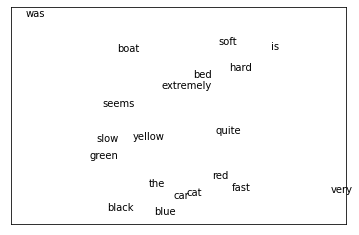

In [59]:
import matplotlib.pyplot as plt

# 把前兩個主成分提取出來，然後轉換成新的單詞向量
components = pca(embedding.embeddings,2)
transformed = transform(embedding.embeddings,components)

# 用散佈圖方式畫出這些點，
fig,ax = plt.subplots()
ax.scatter(*zip(*transformed),marker='.',color='w')

# 在每個單詞向量的相應位置上，加上文字標記
for word,idx in vocab.w2i.items():
  ax.annotate(word,transformed[idx])

# 把坐標軸隱藏起來
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

# RNN遞迴神經網路
```
output[o] = dot(w[o],input) + b[o]
```
使用兩組權重：  
一組用於輸入，一組用於輸出
```
output[o] = dot(w[o],input) + dot(u[o],hidden) + b[o]
```


對輸入中，第一個會不斷變動地維度進行處理
* 加總層/取平均：失去單詞順序等資訊
* RNN遞迴神經網路(Recurrent Neural Network)：使不同輸入在訓練時呈現**隱藏狀態**。且每次的輸入都會結合前一個的輸出並做為新的隱藏狀態→使網路記住所有的輸入及順序，並依此建構出模型的輸出

### 建構RNN遞迴層
可以接受單一的輸入，並在每次調用時，維持一個隱藏狀態  
  
不良調性： 
1. 每次一調用它，每個隱藏層都會用來更新輸入
2. 每次調用它時，整個引層狀態都會被複寫掉

In [60]:
import math

def tanh(x:float) ->float:
  # 如果x非常大或非常小，tanh就會非常接近-1或1
  # 由於math.exp(1000)會發生錯誤，因此需要檢查
  if x < -100 : return -1
  elif x > 100 : return 1

  emx2 = math.exp(-2*x)
  return (1-emx2)/(1+emx2)

In [61]:
class SimpleRnn(Layer):

  def __init__(self,input_dim:int,hidden_dim:int) ->None:
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim

    self.w = random_tensor(hidden_dim,input_dim,init="xavier") 
    self.u = random_tensor(hidden_dim,input_dim,init="xavier") 
    self.b = random_tensor(hidden_dim) 
  
    reset_hidden_state()

  def reset_hidden_state(self) ->None:
    self.hidden = [0 for _ in range(self.hidden_dim)]
  
  def forward(self,input:Tensor)->Tensor:
    self.input = input
    self.prev_hidden = self.hidden

    a = [(dot(self.w[h],input)+dot(self.u[h],self.hidden)+self.b[h]) for h in range(self.hidden_dim)]

    self.hidden_dim = tensor_apply(tanh,a)
    return self.hidden
  
  def backward(self,gradient:Tensor):
    # 透過tanh進行反向傳播
    a_grad = [gradient[h]*(1-gradient[h]**2) for h in range(self.hidden_dim)]

    # b 的梯度與 a 相同 
    self.b_grad = a_grad

    # 每個 w[h][i] 都要與 input[i]相乘，再加上a[h]
    # 因此每個 w_grad[h][i] = a_grad[h] * input[i]
    self.w_grad = [[a_grad[h]*self.input[i] for i in range(self.input_dim)] for h in range(self.output_dim)]

    # 每個 u[h][h2] 都要與 hidden[h2]相乘，再加上a[h]
    # 因此每個 u_grad[h][h2] = a_grad[h] * prev_hidden[h2]
    self.u_grad = [[a_grad[h]*self.prev_hidden[h2] for h2 in range(self.hidden_dim)] for h in range(self.hidden_dim)]

    # 每個 input[i] 都要與 w[h][i]相乘，再加上a[h]
    # 因此每個 input_grad[i] = sum(a_grad[h] * w[h][i] for h in ...)
    return [sum(a_grad(h)*self.w[h][i] for h in range(self.hidden_dim))for i in range(self.input_dim)]
  
  def params(self) ->Iterable[Tensor]:
    return [self.w,self.u,self.b]
  
  def grads(self) ->Iterable[Tensor]:
    return [self.w_grad,self.u_grad,self.b_grad]


## 字元級RNN

In [62]:
companies = ["Airbnb","DoorDash","Stripe","Cruise","Instacart","Dropbox","Coinbase","Zapier","Ginkgo Bioworks","Rappi","Gusto","Scale AI","PagerDuty","Flexport","Segment","Reddit","MessageBird","Brex","Gitlab","Faire","Relativity Space","Amplitude","Checkr","Meesho","GOAT Group","Podium","Rippling","Helion Energy","Fivetran","Momentus","Webflow","Boom","Razorpay","Twitch","Weave","Retool","Iconlad","GoCardless","PlanGrid","Mixpanel","Benchling","Front","Goldbelly","Snapdocs","Modern Health","ShipBob","MBX","Standard Cognition","Embark Trucks","The Athletics","SendBird","Lattice","Turepill","Scribd","Atomwise","Rescale","EquipmentShare","Newfront Insurance","GrubMarket","InfluxData","People.ai","Xendit","Ridecell","Shipper","MatterPort","Sift","Duffel","Vouch","Algolia","Mux","Presto","NURX","EasyPost","Outschool","Mattermost","Observe.AI ","Modern Treasury","Nova Creadit","Proxy","Flock Safety","OkCredit","UpKeep","Optimizely","Heap","SingleStore","WePay","Khartabook","Weebly","Geoko Robotics","Fivestars","Squire Technology","CoreOS","Lambda School","PAYFAZZ","ClearTax","Clever","Volansi","Heroku","Solugen","Canbly","H1"]
assert len(companies) == 101

In [63]:
vocab = Vocabulary([c for company in companies for c in company])

在公司名稱加入特殊標記

In [ ]:
START = "^"
STOP = "$"

vocab.add(START)
vocab.add(STOP)

針對每個字元進行one-hot編碼，並讓它通過兩個SimpleRNN  
再運用線性層可能的下一個字元生成相應的分數

In [ ]:
HIDDEN_DIM = 32

rnn1 = SimpleRnn(input_dim=vocab.size,hidden_dim=HIDDEN_DIM)]
rnn2 = SimpleRnn(input_dim=HIDDEN_DIM,hidden_dim=HIDDEN_DIM)]
linear = Linear(input_dim=HIDDEN_DIM,output_dim=vocab.size)

model = Sequential([rnn1,rnn2,linear])

In [64]:
vocab = Vocabulary([c for company in companies for c in companies])